### CNN Convolution Task

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)
    
    train_train_images, validation_images, train_train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)
    
    return (train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_targets), (test_images, test_targets) = mnist.load_data()


(train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)

print(train_images.shape, train_oh_targets.shape)
print(validation_images.shape, validation_oh_targets.shape)
print(test_images.shape, test_oh_targets.shape)

(60000, 28, 28) (60000, 10)
(12000, 28, 28) (12000, 10)
(10000, 28, 28) (10000, 10)


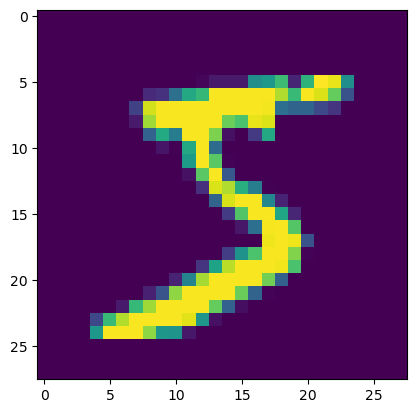

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0])
plt.show()

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))
# input = 1
# kernel = 3 * 3 = 9
# filter = 16
# 9 * 16 + 16 = 160

x = Conv2D(filters = 16, kernel_size= 3, strides=1, padding='same',activation='relu')(input_tensor)

# input = 16
# kernel = 4 * 4 = 16
# filter = 32
# 16 * 16 * 32 + 32 = 8224
x = Conv2D(filters = 32, kernel_size= 4, strides=1, padding='same',activation='relu')(x)

# input = 32
# kernel = 4 * 4 = 16
# filter = 64
# 32 * 16 * 64 + 64 = 32832

x = Conv2D(filters = 64, kernel_size= 4, strides=1,activation='relu')(x)

x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs= input_tensor, outputs = output)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       460,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,296 (1.92 MB)

 Trainable params: 503,296 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5',
    monitor='var_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)



history = model.fit(x=train_images, 
                    y=train_oh_targets,
                    validation_data= (validation_images, validation_oh_targets),
                    batch_size=64,
                    epochs=20,
                    callbacks = [mcp_cb, rlr_cb, ely_cb]
                   )

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - acc: 0.8808 - loss: 0.3710 - val_acc: 0.9842 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - acc: 0.9861 - loss: 0.0457 - val_acc: 0.9902 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - acc: 0.9906 - loss: 0.0294 - val_acc: 0.9935 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - acc: 0.9936 - loss: 0.0212 - val_acc: 0.9958 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - acc: 0.9949 - loss: 0.0173 - val_acc: 0.9950 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - acc: 0.9956 - loss: 0.0122 - val_acc: 0.9967 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - acc: 0.9953 - loss: 0.0129 - val_acc: 0.9980 - val_loss: 0.0059 - learning_rate:

In [17]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_targets, batch_size=64, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9927 - loss: 0.0272


[0.02312508411705494, 0.9944000244140625]

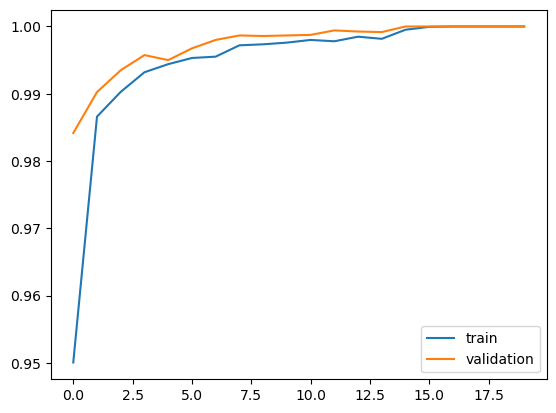

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))


x = Conv2D(filters = 16, kernel_size= 3, strides=1, padding='same',activation='relu')(input_tensor)
x = Conv2D(filters = 32, kernel_size= 4, strides=1, padding='same',activation='relu')(x)
x = Conv2D(filters = 64, kernel_size= 4, strides=1,activation='relu')(x)

x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs= input_tensor, outputs = output)
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │       460,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,296 (1.92 MB)

 Trainable params: 503,296 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5',
    monitor='var_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)



history = model.fit(x=train_images, 
                    y=train_oh_targets,
                    validation_data= (validation_images, validation_oh_targets),
                    batch_size=64,
                    epochs=20,
                    callbacks = [mcp_cb, rlr_cb, ely_cb]
                   )

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - acc: 0.8732 - loss: 0.3945 - val_acc: 0.9849 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - acc: 0.9822 - loss: 0.0580 - val_acc: 0.9928 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - acc: 0.9879 - loss: 0.0393 - val_acc: 0.9926 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - acc: 0.9897 - loss: 0.0334 - val_acc: 0.9934 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - acc: 0.9913 - loss: 0.0277 - val_acc: 0.9962 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - acc: 0.9930 - loss: 0.0214 - val_acc: 0.9976 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - acc: 0.9942 - loss: 0.0210 - val_acc: 0.9974 - val_loss: 0.0086 - learning_rate:

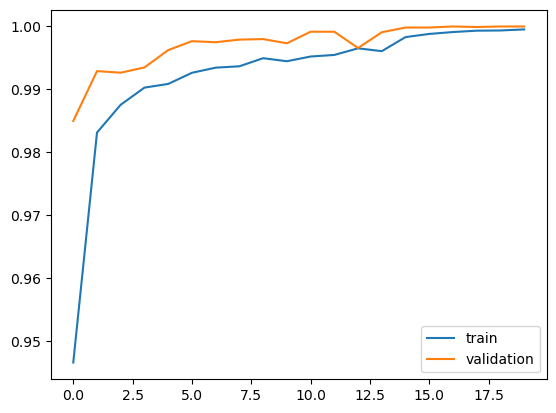

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [15]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_targets, batch_size=64, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9927 - loss: 0.0272


[0.02312508411705494, 0.9944000244140625]

In [16]:
pred_proba = model.predict(np.expand_dims(test_images[30], axis=0))
print('softmax output:', pred_proba)

# argmax() : 가장 높은 값의 인덱스를 찾아서 표기하는 함수
pred = np.argmax(np.squeeze(pred_proba))
print('predicted target value:', pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
softmax output: [[2.0498166e-23 1.8165726e-13 3.9108311e-16 1.0000000e+00 6.2685646e-17
  3.3542353e-12 5.7568494e-20 4.8896049e-13 8.3029592e-14 1.0009786e-12]]
predicted target value: 3
